In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

In [2]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

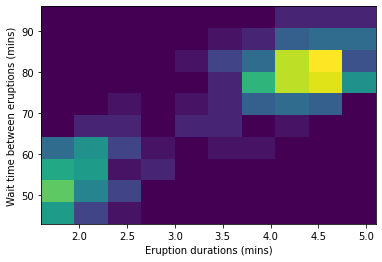

In [3]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

In [4]:
data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([ 4.28966197, 79.96811517]), array([ 2.03638845, 54.47851638])], sigma=[array([[ 0.16996844,  0.94060932],
       [ 0.94060932, 36.04621132]]), array([[ 0.06916767,  0.43516762],
       [ 0.43516762, 33.69728207]])], gamma=array([0.64412714, 0.35587286]))

In [5]:
import torch
import torch.utils.data as tdata
from vaes_ptorch import VAE, GaussianMLP, TrainArgs, train

In [6]:
scaled = 2 * (data - data.min(0)) / (data.max(0) - data.min(0)) - 1

In [48]:
dataset = tdata.TensorDataset(torch.from_numpy(scaled).float())
dataloader = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)
num_latents = 1
encoder = GaussianMLP(in_dim=2, h_dims=[16, 16], out_dim=num_latents)
decoder = GaussianMLP(in_dim=num_latents, h_dims=[16, 16], out_dim=2)
vae = VAE(encoder=encoder, decoder=decoder)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=5 * 1e-3)
train_args = TrainArgs(num_epochs=100, print_every=100, smoothing=0.9)

In [49]:
vae = train(data=dataloader, vae=vae, optimizer=optimizer, args=train_args)

Step: 100 | ELBO: -0.05389
NLL: -0.03463 | KL: 0.00129
Step: 200 | ELBO: -0.02905
NLL: -0.06380 | KL: 0.00197
Step: 300 | ELBO: -0.03161
NLL: 0.00589 | KL: 0.00349


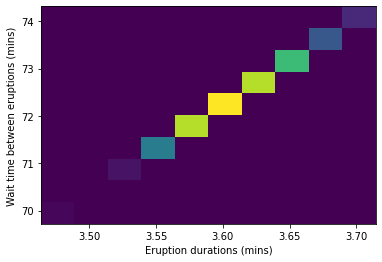

In [50]:
test = torch.from_numpy(scaled).float()

vae.eval()
with torch.no_grad():
    out = vae(test)
    xy = (out.mu_x.detach().numpy() + 1) * 0.5 * (
        data.max(0) - data.min(0)
    ) + data.min(0)
    plt.hist2d(xy[:, 0], xy[:, 1], alpha=1.0)
    plt.xlabel("Eruption durations (mins)")
    plt.ylabel("Wait time between eruptions (mins)");